# k-Nearest Neighbor & Nearest Class Centroid Implementation from scratch and using sklearn
## Nikos Andriotis

In [ ]:
import os # a portable way of using operating system dependent functionality, such as reading data from a file!
import urllib.request # for opening and reading URLs
import gzip # for file extraction
import shutil # for file copying
import codecs # for encoding reasons, this will be explained later
import numpy as np # the "from scratch" part
import matplotlib.pyplot as plt # to have a visual help
import sys # to have a visual help
import time # to keep track of execution time
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid

In order to use the data inside the 4 files from <a href='http://yann.lecun.com/exdb/mnist/'>MNIST</a>, we first have to download them. After that, since they are in a .gz file format we have to unzip them.

Thus, our two prerequisites are:

1. Download the .gz files
2. Extract them

## The "Download" part
Because I want this project to be as universal as possible, I store the files inside the folder containing this notebook locally.

In [ ]:
# Define where you want your files to be downloaded
path_to_store = "./MNIST/"
# Create a directory there
os.makedirs(path_to_store)

# Store the URLs of the 4 files from the MNIST website
urls = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']

for url in urls:
    
    name_of_file = url.split('/')[-1]
    urllib.request.urlretrieve(url, path_to_store + name_of_file)

print(f"[\u2713] All files were downloaded!")

[✓] All files were downloaded!


## The "Extract" part


Lets create a list containing all the file names

In [ ]:
files = os.listdir(path_to_store)
files

['t10k-images-idx3-ubyte.gz',
 'train-images-idx3-ubyte.gz',
 'train-labels-idx1-ubyte.gz',
 't10k-labels-idx1-ubyte.gz']

For each file in this list, if it ends in .gz, open it in read binary mode (since the file is in binary), and copy its contents into another file (in write binary mode), with the same name, without the .gz ending.

Later remove all the .gz files since we are not going to be using them

In [ ]:
files = os.listdir(path_to_store)

for file in files:
    if file.endswith('gz'):
        with gzip.open(path_to_store + file, 'rb')  as f_in:
            with open(path_to_store + file.split('.')[0], 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

for file in files:
    os.remove(path_to_store + file)

## The "Store Properly" part 

The format for label files as specified by MNIST is:

* 4 byte magic number **2049**
* 4 byte number of labels
* 1 unsigned byte per label

The format for image files as specified by MNIST is:

* 4 byte magic number **2051**
* 4 byte num of images
* 4 byte num of rows
* 4 byte num of cols
* 1 unsigned byte per pixel

Let's make an example for a better understanding

In [ ]:
first_file = os.listdir(path_to_store)[0]
first_file

'train-labels-idx1-ubyte'

In [ ]:
with open(path_to_store + first_file, 'rb') as f:
    data = f.read()
    magic_number = data[0:4]
    num_of_images = data[4:8]
    num_of_rows = data[8:12]
    num_of_cols = data[12:16]

In [ ]:
magic_number, num_of_images, num_of_rows, num_of_cols

(b'\x00\x00\x08\x01', b'\x00\x00\xea`', b'\x05\x00\x04\x01', b'\t\x02\x01\x03')

They are in binary form, representing hexadecimal values, but the escape sequence is unneeded and prevents data extraction.

We need to do two things:

1. Clear the binaries from the "\x" characters.
2. Convert the hexadecimal representations to decimal.

In [ ]:
cleared_hex = codecs.encode(num_of_images, 'hex') # step 1 completed!
cleared_hex

b'0000ea60'

In [ ]:
converted_hex = int(cleared_hex, 16)
converted_hex

60000

Lets create a function that does all this!

In [ ]:
def get_int(b):
    return int(codecs.encode(b, 'hex'), 16)

In [ ]:
files = os.listdir(path_to_store)

for file in files:
    if file.endswith('ubyte'):
        with open(path_to_store + file, 'rb') as f:
            data = f.read()
            magic_number = get_int(data[:4])
            length = get_int(data[4:8])
            if (magic_number == 2051):
                images = np.frombuffer(data, dtype= np.uint8, offset = 16).reshape(length, 784)
                if(length == 60000):
                    train_images = images/255 # normalization
                if(length == 10000):
                    test_images = images/255 # normalization
            elif (magic_number == 2049):
                labels = np.frombuffer(data, dtype= np.uint8, offset = 8).reshape(length)
                if(length == 60000):
                    train_labels = labels
                if(length == 10000):
                    test_labels = labels

Let's see what we stored!

In [ ]:
train_images.shape, train_labels.shape

((60000, 784), (60000,))

In [ ]:
test_images.shape, test_labels.shape

((10000, 784), (10000,))

Each image is one row of 784 values (28x28)
The same goes for the labels

In [ ]:
train_images[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Or, in some form we can understand

(<matplotlib.image.AxesImage at 0x7fc3b2bf4ad0>, 5)

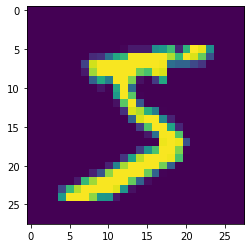

In [ ]:
plt.imshow(train_images[0].reshape(28,28)), train_labels[0]

## SCRATCH : Nearest Class Centroid implementation

Since this method first creates the per-class centroid, and then computes the proximity of each test image, instead of looking every training image, it only looks at 10 centroids.

Thus, I suspect it will be far quicker than the KNN algorithm, so I will implement it first.

We need to do three things:

1. Find a way to compute distance between two vectors.
2. For each class of images (0,...,9) take the mean to calculate the centroid.
3. Predict for each test image and calculate its accuracy.

We have to first find a way to compute the distance. From Wikipedia:


$$d(p,q) = \sqrt{(p_1- q_1)^2 + (p_2 - q_2)^2+\cdots+(p_i - q_i)^2+\cdots+(p_n - q_n)^2}$$

In [ ]:
def euclidean_distance(im1, im2):
    return np.sqrt(np.sum(np.square(im1-im2)))

Then find the centroid by calculating the mean, column wise.

In [ ]:
centroids = np.array([train_images[train_labels == i].mean(axis=0) for i in range(10)])

Predict for each test image and increment a value if you are correct.

In [ ]:
centroid_predictions = 0

start = time.time()
for test_image, test_label in zip(test_images, test_labels):
    minimum_distance = sys.maxsize
    for i in range(len(centroids)):
        distance = euclidean_distance(centroids[i], test_image)
        if distance < minimum_distance:
            minimum_distance = distance
            prediction = i
    if prediction == test_label:
        centroid_predictions += 1
end = time.time()

print(f"How many the algorithm got correct: {(centroid_predictions/10000)*100}%")
print(f"Time spent: {end - start} seconds")

How many the algorithm got correct: 82.03%
Time spent: 1.700080394744873 seconds


## SCRATCH : k-Nearest Neighbor implementation

Now, since we don't compute the mean, for **each** test image, we take **each** train image and compute the distance between them.

We need the smallest distance so we store which image corresponds to the minimum distance. After we have seen all images, we predict (based on proximity).

If the prediction is correct, we increment a count by one.

In [ ]:
neighbor_predictions = 0

start = time.time()
for test_image, test_label in zip(test_images, test_labels):
    minimum_distance = sys.maxsize
    for train_image, train_label in zip(train_images, train_labels):
        current_distance = euclidean_distance(train_image, test_image)
        if current_distance < minimum_distance:
            minimum_distance = current_distance
            prediction = train_label
    if prediction == test_label:
        neighbor_predictions += 1   
end = time.time()

print("Percentage: ", (neighbor_predictions/10000)*100, "%")
print(f"Time spent: {(end - start)/3600} hours")

Percentage:  96.91 %
Time spent: 2.442024618917041 hours


## SCIKIT-LEARN : Nearest Class Centroid implementation

As I saw, despite the good accuracy scored, it takes a long time to complete. Trying to calculate the 3-NN classifier will take even longer. This is why I will use the sklearn module and compute the classifiers and see the difference in accuracy and time of execution.

In [ ]:
start = time.time()
model = NearestCentroid()
model.fit(train_images, train_labels)
score = model.score(test_images, test_labels)
end = time.time()
print(f"accuracy: {score*100} | time spent: {end-start} seconds")

accuracy: 82.03 | time spent: 0.414093017578125 seconds


## SCIKIT-LEARN : k-Nearest Neighbor implementation

In [ ]:
for k in range(1, 4, 2):
    start = time.time()
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_images, train_labels)
    score = model.score(test_images, test_labels)
    end = time.time()
    print(f"k: {k}, accuracy: {score*100} | time spent: {end-start} seconds")

k: 1, accuracy: 96.91 | time spent: 779.0275430679321 seconds
k: 3, accuracy: 97.05 | time spent: 788.6615052223206 seconds


## Closing Remarks

From my calculations I can tell that despite the accuracy being pretty much the same, the time required is incredibly different:

* Scratch Centroid : 82.03% | ~2 secs
* Scikit Centroid : 82.03% | ~0.5 secs

* Scratch 1-NN : 96.91% | ~2.5 hours
* Scikit 1-NN : 96.91% | ~45 secs (jupyter) | ~13 minutes (collab)

* Scratch 3-NN : 97.05% | ~5 hours (this is an estimate)
* Scikit 3-NN : 97.05% | ~40 secs (jupyter) | ~14 minutes (collab)

